# Parliamentary Speech Segmentation Analysis

This notebook analyzes parliamentary speech patterns and validates segmentation approaches for **Austrian Parliament** (English/German) and **Croatian Parliament** (English/Croatian) datasets and **British Parliament** (English only).

## Key Features:
- **Embedding Analysis**: Compare native vs English embeddings
- **Enhanced Segmentation**: Multi-signal boundary detection with agenda awareness
- **Quality Validation**: Within vs between segment similarity analysis
- **Cross-Parliament & Cross-Language Comparison**: Unified analysis across different parliamentary systems and languages

## Pipeline:
1. Load data with pre-computed embeddings
2. Analyze embedding similarities and text length relationships
3. Apply sophisticated segmentation algorithm with native language support
4. Validate segmentation quality
5. Compare English vs native language segmentation performance

In [24]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Load the data with embeddings
AT_combined = pd.read_pickle(r"data folder\AT\AT_combined_with_embeddings.pkl")
HR_combined = pd.read_pickle(r"data folder\HR\HR_combined_with_embeddings.pkl")
GB = pd.read_pickle(r"data folder\GB\GB_with_speech_embeddings.pkl")

print(f"✅ Loaded Austrian data: {AT_combined.shape}")
print(f"✅ Loaded Croatian data: {HR_combined.shape}")
print(f"✅ Loaded British data: {GB.shape}")


✅ Loaded Austrian data: (231759, 28)
✅ Loaded Croatian data: (504338, 28)
✅ Loaded British data: (670912, 27)



AUSTRIAN PARLIAMENT (English vs German)
📈 Statistics: 231,759 pairs analyzed
  • Mean similarity: 0.8636
  • Std similarity: 0.0503
  • Min-Max: 0.3826 - 1.0000
📈 Statistics: 231,759 pairs analyzed
  • Mean similarity: 0.8636
  • Std similarity: 0.0503
  • Min-Max: 0.3826 - 1.0000

CROATIAN PARLIAMENT (English vs Croatian)

CROATIAN PARLIAMENT (English vs Croatian)
📈 Statistics: 504,338 pairs analyzed
  • Mean similarity: 0.8390
  • Std similarity: 0.0498
  • Min-Max: 0.3137 - 1.0000
📈 Statistics: 504,338 pairs analyzed
  • Mean similarity: 0.8390
  • Std similarity: 0.0498
  • Min-Max: 0.3137 - 1.0000


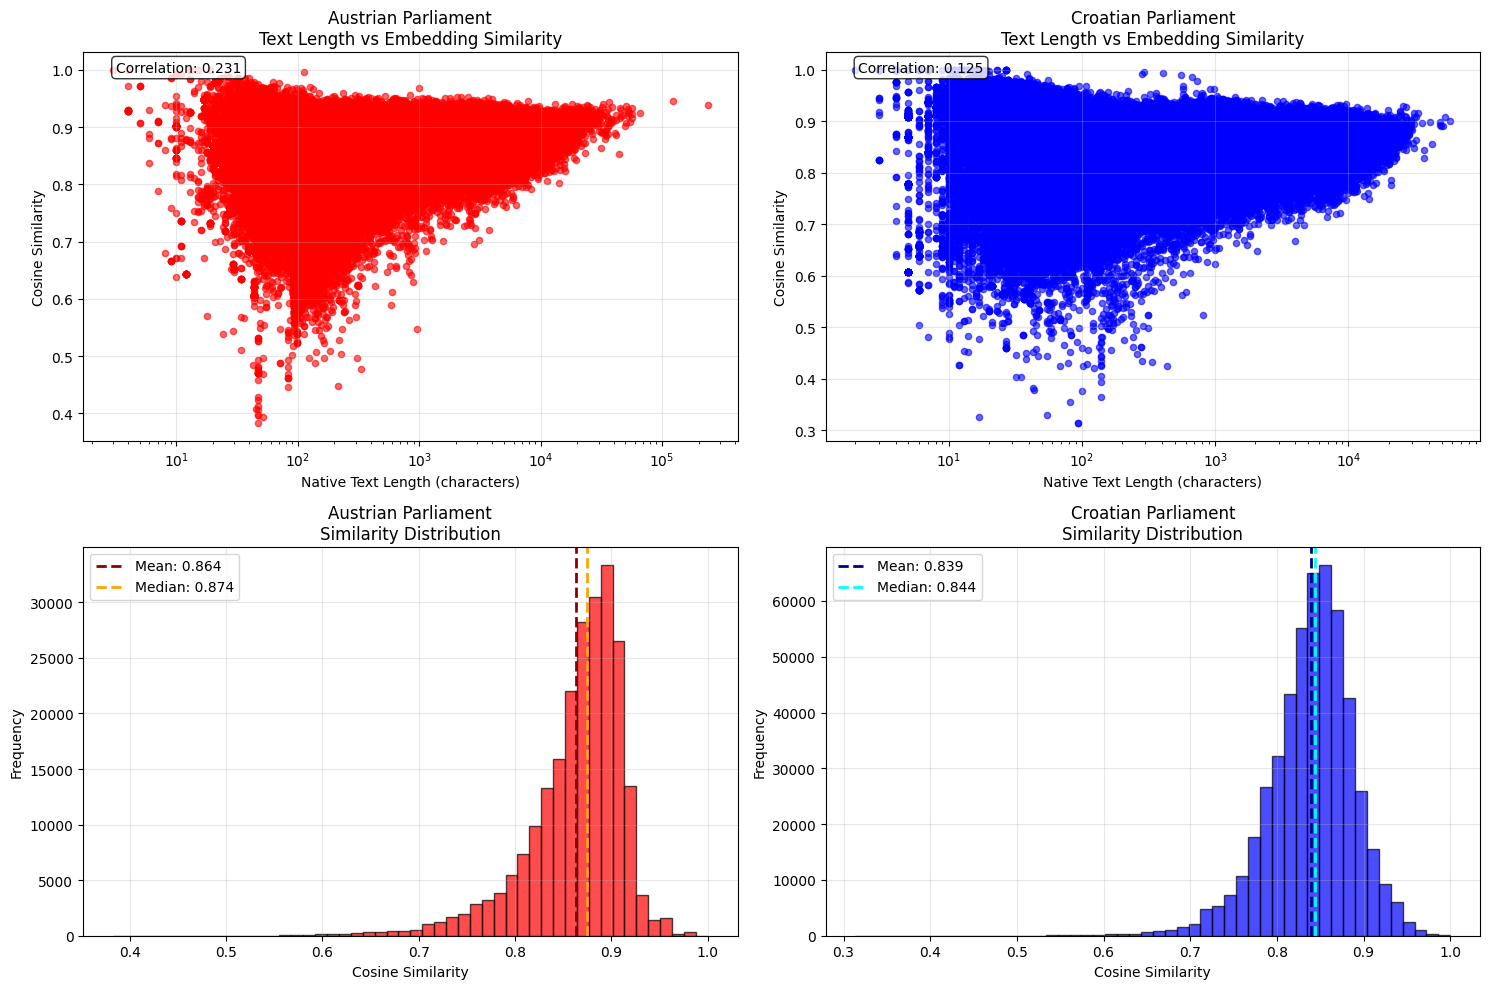


🎯 CROSS-PARLIAMENT COMPARISON
Austrian (EN-DE): Mean=0.8636, Std=0.0503
Croatian (EN-HR): Mean=0.8390, Std=0.0498


In [ ]:
# === EMBEDDING SIMILARITY ANALYSIS ===

def analyze_embedding_similarities(dataset, english_col, native_col, parliament_name):
    """Comprehensive analysis of native vs English embedding similarities"""
    print(f"\n{parliament_name}")
    print("=" * 50)
    
    valid_data = dataset.dropna(subset=[english_col, native_col])
    
    similarities = []
    text_lengths = []
    
    for idx, row in valid_data.iterrows():
        similarity = cosine_similarity([row[english_col]], [row[native_col]])[0][0]
        similarities.append(similarity)
        
        native_text = row.get('Text_native', row.get('Text', ''))
        text_lengths.append(len(native_text))
    
    print(f"📈 Statistics: {len(similarities):,} pairs analyzed")
    print(f"  • Mean similarity: {np.mean(similarities):.4f}")
    print(f"  • Std similarity: {np.std(similarities):.4f}")
    print(f"  • Min-Max: {np.min(similarities):.4f} - {np.max(similarities):.4f}")
    
    return similarities, text_lengths

# Analyze embeddings for both parliaments
at_similarities, at_lengths = analyze_embedding_similarities(
    AT_combined, 'Speech_Embeddings_english', 'Speech_Embeddings_native_language',
    "AUSTRIAN PARLIAMENT (English vs German)"
)

hr_similarities, hr_lengths = analyze_embedding_similarities(
    HR_combined, 'Speech_Embeddings_english', 'Speech_Embeddings_native_language', 
    "CROATIAN PARLIAMENT (English vs Croatian)"
)


print(f"\n🎯 CROSS-PARLIAMENT COMPARISON")
print("=" * 50)
print(f"Austrian (EN-DE): Mean={np.mean(at_similarities):.4f}, Std={np.std(at_similarities):.4f}")
print(f"Croatian (EN-HR): Mean={np.mean(hr_similarities):.4f}, Std={np.std(hr_similarities):.4f}")

In [27]:
# === ENHANCED MULTI-SIGNAL SEGMENTATION WITH NATIVE LANGUAGE SUPPORT ===

# Native language agenda keywords for better segmentation
native_agenda_keywords = {
    "AUSTRIAN (German)": [
        'tagesordnung', 'tagesordnungspunkt', 'punkt', 'verhandlung', 
        'behandlung', 'nächster', 'weiter', 'fortsetzen'
    ],
    "CROATIAN (Croatian)": [
        'dnevni', 'red', 'točka', 'tačka', 'sljedeći', 'sljedeće',
        'prijedlog', 'zakon', 'tema', 'nastavljamo', 'prelazimo',
    ]
}

def create_enhanced_segments_native(dataset, embedding_col='Speech_Embeddings_english', 
                                  text_col='Text', parliament_name="", 
                                  text_id_col='Text_ID', window_size=5, min_segment_size=10):
    """Enhanced segmentation with native language support"""
    
    # Use native keywords if available, otherwise default English keywords
    if parliament_name in native_agenda_keywords:
        agenda_keywords = native_agenda_keywords[parliament_name]
        print(f"🌍 Using native keywords for {parliament_name}: {agenda_keywords[:3]}...")
    else:
        agenda_keywords = [
            'agenda', 'proceed', 'point', 'item',
            'topic', 'next', 'following', 'move on'
        ]
        print(f"🔤 Using English keywords for {parliament_name}")
    
    def boundary_in_signal(boundary, signal_name, similarity_signals, window_size):
        """Check if boundary corresponds to a signal"""
        signal = similarity_signals.get(signal_name, [])
        if len(signal) == 0:
            return False
        
        if signal_name == 'windowed':
            return boundary - window_size >= 0 and boundary - window_size < len(signal)
        else:
            return boundary - 1 >= 0 and boundary - 1 < len(signal)
    
    all_segments = []
    segment_stats = {
        'total_segments': 0, 'agenda_breaks': 0, 'multi_signal_breaks': 0,
        'similarity_breaks': 0, 'chairperson_breaks': 0
    }
    
    unique_text_ids = dataset[text_id_col].unique()
    
    for text_id in tqdm(unique_text_ids, desc=f"Segmenting {parliament_name}"):
        text_data = dataset[dataset[text_id_col] == text_id].reset_index(drop=True)
        sitting_length = len(text_data)
        
        if sitting_length < min_segment_size:
            segment = {
                'Text_ID': text_id, 'Segment_ID': f"{text_id}_seg_1",
                'Start_Index': 0, 'End_Index': sitting_length - 1,
                'Speech_Count': sitting_length, 'Break_Type': 'single_speech'
            }
            all_segments.append(segment)
            segment_stats['total_segments'] += 1
            continue

        embeddings = np.array(text_data[embedding_col].tolist())

        # === NATIVE LANGUAGE AGENDA DETECTION ===
        agenda_boundaries = set()
        agenda_signals = []

        for i, (_, row) in enumerate(text_data.iterrows()):
            agenda_score = 0
            
            if 'Speaker_role' in row and pd.notna(row['Speaker_role']):
                if 'Chairperson' in str(row['Speaker_role']):
                    text = str(row[text_col]).lower() if pd.notna(row[text_col]) else ""
                    
                    # Count how many agenda keywords are present
                    keyword_count = sum(1 for keyword in agenda_keywords if keyword in text)
                    
                    # Score based on keyword count (more keywords = higher score)
                    if keyword_count > 0:
                        agenda_score = min(1.0, keyword_count * 0.3)  # Cap at 1.0, each keyword adds 0.3
                    
                    # Special handling for session start
                    if agenda_score == 0 and i == 0:
                        agenda_score = 0.3
            
            agenda_signals.append(agenda_score)
            
            # Add as agenda boundary if score is significant enough
            if (agenda_score >= 0.6 and i >= min_segment_size and 
                (sitting_length - i) >= min_segment_size):
                agenda_boundaries.add(i)

        # === SIMILARITY ANALYSIS ===
        similarity_signals = {}
        
        # Windowed similarity
        if len(embeddings) > window_size * 2:
            similarities = []
            for i in range(len(embeddings) - window_size):
                if i + 2 * window_size <= len(embeddings):
                    window1 = np.mean(embeddings[i:i + window_size], axis=0)
                    window2 = np.mean(embeddings[i + window_size:i + 2*window_size], axis=0)
                    sim = cosine_similarity(window1.reshape(1, -1), window2.reshape(1, -1))[0][0]
                    similarities.append(sim)
            similarity_signals['windowed'] = np.array(similarities)
        
        # Point-to-point similarity
        if len(embeddings) > 6:
            point_sims = []
            for i in range(len(embeddings) - 1):
                sim = cosine_similarity(
                    embeddings[i].reshape(1, -1),
                    embeddings[i + 1].reshape(1, -1)
                )[0][0]
                point_sims.append(sim)
            similarity_signals['point_to_point'] = np.array(point_sims)

        if not similarity_signals:
            segment = {
                'Text_ID': text_id, 'Segment_ID': f"{text_id}_seg_1",
                'Start_Index': 0, 'End_Index': sitting_length - 1,
                'Speech_Count': sitting_length, 'Break_Type': 'no_signals'
            }
            all_segments.append(segment)
            segment_stats['total_segments'] += 1
            continue

        # === BOUNDARY DETECTION (Natural Thresholds) ===
        candidate_boundaries = set(agenda_boundaries)
        
        for signal_name, signal in similarity_signals.items():
            if len(signal) > 0:
                signal_mean = np.mean(signal)
                signal_std = np.std(signal)
                threshold = signal_mean - signal_std
                
                if signal_name == 'windowed':
                    offset = window_size
                else:
                    offset = 1
                
                for i in range(len(signal)):
                    boundary_pos = i + offset
                    
                    if (signal[i] < threshold and 
                        boundary_pos >= min_segment_size and 
                        (sitting_length - boundary_pos) >= min_segment_size):
                        candidate_boundaries.add(boundary_pos)

        candidates = sorted(list(candidate_boundaries))

        # === BOUNDARY SELECTION (Quality-Based) ===
        if candidates:
            candidate_scores = []
            for c in candidates:
                score = 0
                
                if c < len(agenda_signals):
                    score += agenda_signals[c] * 5.0
                
                for signal_name, signal in similarity_signals.items():
                    signal_mean = np.mean(signal)
                    
                    if signal_name == 'windowed' and c - window_size >= 0 and c - window_size < len(signal):
                        deviation = signal_mean - signal[c - window_size]
                        score += max(0, deviation) * 5.0
                    elif signal_name == 'point_to_point' and c - 1 >= 0 and c - 1 < len(signal):
                        deviation = signal_mean - signal[c - 1]
                        score += max(0, deviation) * 3.0
                
                candidate_scores.append((c, score))
            
            boundaries = sorted([c for c, score in candidate_scores if score > 0])
        else:
            boundaries = []

        # Validate boundaries (ensure minimum spacing)
        validated_boundaries = []
        for boundary in boundaries:
            if not validated_boundaries or (boundary - validated_boundaries[-1]) >= min_segment_size:
                validated_boundaries.append(boundary)

        # Create segments
        segment_breaks = [0] + validated_boundaries + [sitting_length]
        segment_breaks = sorted(list(set(segment_breaks)))
        
        for seg_idx in range(len(segment_breaks) - 1):
            start_idx = segment_breaks[seg_idx]
            end_idx = segment_breaks[seg_idx + 1] - 1
            
            break_type = 'enhanced'
            if seg_idx < len(validated_boundaries):
                boundary = validated_boundaries[seg_idx]
                if boundary in agenda_boundaries:
                    break_type = 'agenda'
                    segment_stats['agenda_breaks'] += 1
                elif sum(boundary_in_signal(boundary, s, similarity_signals, window_size) 
                        for s in similarity_signals.keys()) > 1:
                    break_type = 'multi_signal'
                    segment_stats['multi_signal_breaks'] += 1
                else:
                    break_type = 'similarity'
                    segment_stats['similarity_breaks'] += 1
            
            segment = {
                'Text_ID': text_id, 'Segment_ID': f"{text_id}_seg_{seg_idx + 1}",
                'Start_Index': start_idx, 'End_Index': end_idx,
                'Speech_Count': end_idx - start_idx + 1, 'Break_Type': break_type
            }
            all_segments.append(segment)
            segment_stats['total_segments'] += 1

    return all_segments, segment_stats

def validate_segmentation_quality(dataset, segments, embedding_col):
    """Validate segmentation by comparing within vs between segment similarities with progress tracking"""
    within_similarities = []
    between_similarities = []
    
    text_id_segments = {}
    for segment in segments:
        text_id = segment['Text_ID']
        if text_id not in text_id_segments:
            text_id_segments[text_id] = []
        text_id_segments[text_id].append(segment)
    
    print(f"🔍 Validating segmentation quality across {len(text_id_segments)} sessions...")
    
    for text_id in tqdm(text_id_segments.keys(), desc="Validating segments", unit="session"):
        text_segments = text_id_segments[text_id]
        text_data = dataset[dataset['Text_ID'] == text_id].reset_index(drop=True)
        
        # Within-segment similarities (sample to avoid explosion)
        for segment in text_segments:
            start_idx, end_idx = segment['Start_Index'], segment['End_Index']
            
            if end_idx > start_idx:
                max_comparisons = 20  # Limit per segment
                comparisons_made = 0
                
                for i in range(start_idx, min(end_idx + 1, len(text_data))):
                    for j in range(i + 1, min(end_idx + 1, len(text_data))):
                        if comparisons_made >= max_comparisons:
                            break
                        
                        if i < len(text_data) and j < len(text_data):
                            emb1, emb2 = text_data.iloc[i][embedding_col], text_data.iloc[j][embedding_col]
                            
                            if emb1 is not None and emb2 is not None:
                                try:
                                    sim = cosine_similarity([emb1], [emb2])[0][0]
                                    within_similarities.append(sim)
                                    comparisons_made += 1
                                except:
                                    continue
                    if comparisons_made >= max_comparisons:
                        break
        
        # Between-segment similarities
        for i in range(len(text_segments) - 1):
            seg1, seg2 = text_segments[i], text_segments[i + 1]
            idx1, idx2 = seg1['End_Index'], seg2['Start_Index']
            
            if idx1 < len(text_data) and idx2 < len(text_data):
                emb1, emb2 = text_data.iloc[idx1][embedding_col], text_data.iloc[idx2][embedding_col]
                
                if emb1 is not None and emb2 is not None:
                    try:
                        sim = cosine_similarity([emb1], [emb2])[0][0]
                        between_similarities.append(sim)
                    except:
                        continue
    
    print(f"✅ Quality validation complete: {len(within_similarities)} within-segment, {len(between_similarities)} between-segment comparisons")
    return within_similarities, between_similarities

# === APPLY TO ALL PARLIAMENTS (INCLUDING NATIVE LANGUAGES) ===

parliament_configs = {
    "AUSTRIAN (English)": {"dataset": AT_combined, "embedding_col": "Speech_Embeddings_english", "text_col": "Text"},
    "AUSTRIAN (German)": {"dataset": AT_combined, "embedding_col": "Speech_Embeddings_native_language", "text_col": "Text_native_language"},
    "CROATIAN (English)": {"dataset": HR_combined, "embedding_col": "Speech_Embeddings_english", "text_col": "Text"},
    "CROATIAN (Croatian)": {"dataset": HR_combined, "embedding_col": "Speech_Embeddings_native_language", "text_col": "Text_native_language"},
    "BRITISH (English)": {"dataset": GB, "embedding_col": "Speech_Embeddings", "text_col": "Text"}
}

print("🔧 ENHANCED MULTI-SIGNAL SEGMENTATION (INCLUDING NATIVE LANGUAGES)")
print("=" * 70)

# CONFIGURABLE PARAMETERS
WINDOW_SIZE = 10          
MIN_SEGMENT_SIZE = 15    

print(f"⚙️ Configuration: window_size={WINDOW_SIZE}, min_segment_size={MIN_SEGMENT_SIZE}")

results = {}
for parliament_name, config in parliament_configs.items():
    print(f"\n{parliament_name} PARLIAMENT")
    print("-" * 40)
    
    dataset = config["dataset"]
    embedding_col = config["embedding_col"]
    text_col = config["text_col"]
    
    # Check if the required columns exist
    if embedding_col not in dataset.columns:
        print(f"❌ Embedding column '{embedding_col}' not found, skipping...")
        continue
    
    if text_col not in dataset.columns:
        print(f"❌ Text column '{text_col}' not found, skipping...")
        continue
    
    # Create segments with configurable parameters
    print("🔄 Creating segments...")
    segments, stats = create_enhanced_segments_native(
        dataset, 
        embedding_col,
        text_col,
        parliament_name,
        window_size=WINDOW_SIZE, 
        min_segment_size=MIN_SEGMENT_SIZE
    )
    
    # Validate quality with progress tracking
    print("🔄 Validating segmentation quality...")
    within_sim, between_sim = validate_segmentation_quality(dataset, segments, embedding_col)
    
    avg_segment_size = len(dataset) / stats['total_segments']
    quality_score = np.mean(within_sim) - np.mean(between_sim) if within_sim and between_sim else 0
    
    results[parliament_name] = {
        'segments': segments, 'stats': stats, 'avg_size': avg_segment_size,
        'quality_score': quality_score, 'within_sim': within_sim, 'between_sim': between_sim
    }
    
    print(f"📊 Segments: {stats['total_segments']:,} (avg size: {avg_segment_size:.1f})")
    print(f"🎯 Break types: {stats['agenda_breaks']:,} agenda + {stats['multi_signal_breaks']:,} multi-signal")
    if quality_score > 0:
        print(f"✅ Quality score: {quality_score:.3f}")
    print(f"📈 Within-segment similarities: {len(within_sim):,}")
    print(f"📉 Between-segment similarities: {len(between_sim):,}")

print(f"\n🏆 SEGMENTATION SUMMARY (ALL LANGUAGES)")
print("=" * 50)
for name, result in results.items():
    total_breaks = result['stats']['agenda_breaks'] + result['stats']['multi_signal_breaks']
    agenda_pct = result['stats']['agenda_breaks'] / max(total_breaks, 1) * 100
    print(f"{name}: {result['stats']['total_segments']:,} segments, {agenda_pct:.1f}% agenda-driven")

🔧 ENHANCED MULTI-SIGNAL SEGMENTATION (INCLUDING NATIVE LANGUAGES)
⚙️ Configuration: window_size=10, min_segment_size=15

AUSTRIAN (English) PARLIAMENT
----------------------------------------
🔄 Creating segments...
🔤 Using English keywords for AUSTRIAN (English)


Segmenting AUSTRIAN (English): 100%|██████████| 1221/1221 [03:29<00:00,  5.83it/s]


🔄 Validating segmentation quality...
🔍 Validating segmentation quality across 1221 sessions...


Validating segments: 100%|██████████| 1221/1221 [02:09<00:00,  9.43session/s]


✅ Quality validation complete: 243385 within-segment, 11308 between-segment comparisons
📊 Segments: 12,529 (avg size: 18.5)
🎯 Break types: 3,371 agenda + 7,937 multi-signal
✅ Quality score: 0.070
📈 Within-segment similarities: 243,385
📉 Between-segment similarities: 11,308

AUSTRIAN (German) PARLIAMENT
----------------------------------------
🔄 Creating segments...
🌍 Using native keywords for AUSTRIAN (German): ['tagesordnung', 'tagesordnungspunkt', 'punkt']...


Segmenting AUSTRIAN (German): 100%|██████████| 1221/1221 [04:55<00:00,  4.14it/s]


🔄 Validating segmentation quality...
🔍 Validating segmentation quality across 1221 sessions...


Validating segments: 100%|██████████| 1221/1221 [02:04<00:00,  9.81session/s]



✅ Quality validation complete: 233965 within-segment, 10837 between-segment comparisons
📊 Segments: 12,058 (avg size: 19.2)
🎯 Break types: 2,097 agenda + 8,740 multi-signal
✅ Quality score: 0.076
📈 Within-segment similarities: 233,965
📉 Between-segment similarities: 10,837

CROATIAN (English) PARLIAMENT
----------------------------------------
🔄 Creating segments...
🔤 Using English keywords for CROATIAN (English)


Segmenting CROATIAN (English): 100%|██████████| 1708/1708 [06:23<00:00,  4.45it/s]


🔄 Validating segmentation quality...
🔍 Validating segmentation quality across 1708 sessions...


Validating segments: 100%|██████████| 1708/1708 [04:05<00:00,  6.95session/s]



✅ Quality validation complete: 502070 within-segment, 23407 between-segment comparisons
📊 Segments: 25,115 (avg size: 20.1)
🎯 Break types: 1,269 agenda + 22,138 multi-signal
✅ Quality score: 0.096
📈 Within-segment similarities: 502,070
📉 Between-segment similarities: 23,407

CROATIAN (Croatian) PARLIAMENT
----------------------------------------
🔄 Creating segments...
🌍 Using native keywords for CROATIAN (Croatian): ['dnevni', 'red', 'točka']...


Segmenting CROATIAN (Croatian): 100%|██████████| 1708/1708 [07:37<00:00,  3.73it/s]



🔄 Validating segmentation quality...
🔍 Validating segmentation quality across 1708 sessions...


Validating segments: 100%|██████████| 1708/1708 [06:43<00:00,  4.24session/s]



✅ Quality validation complete: 504310 within-segment, 23519 between-segment comparisons
📊 Segments: 25,227 (avg size: 20.0)
🎯 Break types: 2,812 agenda + 20,707 multi-signal
✅ Quality score: 0.087
📈 Within-segment similarities: 504,310
📉 Between-segment similarities: 23,519

BRITISH (English) PARLIAMENT
----------------------------------------
🔄 Creating segments...
🔤 Using English keywords for BRITISH (English)


Segmenting BRITISH (English): 100%|██████████| 2209/2209 [14:59<00:00,  2.45it/s]


🔄 Validating segmentation quality...
🔍 Validating segmentation quality across 2209 sessions...


Validating segments: 100%|██████████| 2209/2209 [10:08<00:00,  3.63session/s]



✅ Quality validation complete: 667418 within-segment, 31172 between-segment comparisons
📊 Segments: 33,381 (avg size: 20.1)
🎯 Break types: 120 agenda + 31,052 multi-signal
✅ Quality score: 0.024
📈 Within-segment similarities: 667,418
📉 Between-segment similarities: 31,172

🏆 SEGMENTATION SUMMARY (ALL LANGUAGES)
AUSTRIAN (English): 12,529 segments, 29.8% agenda-driven
AUSTRIAN (German): 12,058 segments, 19.4% agenda-driven
CROATIAN (English): 25,115 segments, 5.4% agenda-driven
CROATIAN (Croatian): 25,227 segments, 12.0% agenda-driven
BRITISH (English): 33,381 segments, 0.4% agenda-driven
AUSTRIAN (English): 12,529 segments, 29.8% agenda-driven
AUSTRIAN (German): 12,058 segments, 19.4% agenda-driven
CROATIAN (English): 25,115 segments, 5.4% agenda-driven
CROATIAN (Croatian): 25,227 segments, 12.0% agenda-driven
BRITISH (English): 33,381 segments, 0.4% agenda-driven


In [28]:
# === LANGUAGE COMPARISON ANALYSIS ===

print("🌍 ENGLISH vs NATIVE LANGUAGE SEGMENTATION COMPARISON")
print("=" * 60)

# Compare segmentation performance between English and native languages
comparison_pairs = [
    ("AUSTRIAN (English)", "AUSTRIAN (German)"),
    ("CROATIAN (English)", "CROATIAN (Croatian)")
]

for english_key, native_key in comparison_pairs:
    if english_key in results and native_key in results:
        english_result = results[english_key]
        native_result = results[native_key]
        
        parliament = english_key.split(" ")[0]
        native_lang = native_key.split("(")[1].rstrip(")")
        
        print(f"\n📊 {parliament} PARLIAMENT COMPARISON")
        print("-" * 40)
        
        # Segment count comparison
        en_segments = english_result['stats']['total_segments']
        native_segments = native_result['stats']['total_segments']
        segment_diff = abs(en_segments - native_segments)
        segment_similarity = 1 - (segment_diff / max(en_segments, native_segments))
        
        print(f"🔢 Segment Count:")
        print(f"  • English: {en_segments:,} segments")
        print(f"  • {native_lang}: {native_segments:,} segments")
        print(f"  • Difference: {segment_diff:,} segments")
        print(f"  • Similarity: {segment_similarity:.3f} (1.0 = identical)")
        
        # Quality score comparison
        en_quality = english_result['quality_score']
        native_quality = native_result['quality_score']
        quality_diff = native_quality - en_quality
        
        print(f"\n⚡ Quality Score Comparison:")
        print(f"  • English: {en_quality:.3f}")
        print(f"  • {native_lang}: {native_quality:.3f}")
        print(f"  • Difference: {quality_diff:.3f} ({'Native better' if quality_diff > 0 else 'English better' if quality_diff < 0 else 'Equal'})")
        
        # Average segment size comparison
        en_avg_size = english_result['avg_size']
        native_avg_size = native_result['avg_size']
        size_diff = native_avg_size - en_avg_size
        
        print(f"\n📏 Average Segment Size:")
        print(f"  • English: {en_avg_size:.1f} speeches/segment")
        print(f"  • {native_lang}: {native_avg_size:.1f} speeches/segment")
        print(f"  • Difference: {size_diff:.1f} speeches")
        
        # Agenda boundaries comparison
        en_agenda = english_result['stats']['agenda_breaks']
        native_agenda = native_result['stats']['agenda_breaks']
        agenda_diff = native_agenda - en_agenda
        
        print(f"\n🎯 Agenda Boundaries Detected:")
        print(f"  • English: {en_agenda:,} agenda breaks")
        print(f"  • {native_lang}: {native_agenda:,} agenda breaks")
        print(f"  • Difference: {agenda_diff:,} ({'Native found more' if agenda_diff > 0 else 'English found more' if agenda_diff < 0 else 'Same'})")
        
        # Overall assessment
        print(f"\n💡 Overall Assessment:")
        if abs(quality_diff) < 0.01 and segment_similarity > 0.9:
            print(f"  • Very similar segmentation between English and {native_lang}")
        elif quality_diff > 0.02:
            print(f"  • {native_lang} shows notably better segmentation quality")
        elif quality_diff < -0.02:
            print(f"  • English shows notably better segmentation quality")
        else:
            print(f"  • Moderate differences between English and {native_lang}")

print(f"\n📊 CROSS-LANGUAGE INSIGHTS:")
print("=" * 40)

# Extract quality scores for comparison
language_quality = {}
for name, result in results.items():
    quality = result['quality_score']
    language_quality[name] = quality

# Sort by quality score
sorted_quality = sorted(language_quality.items(), key=lambda x: x[1], reverse=True)

print("🏆 Segmentation Quality Ranking:")
for i, (name, quality) in enumerate(sorted_quality, 1):
    print(f"  {i}. {name}: {quality:.3f}")

# Analyze native vs English performance
native_better = 0
english_better = 0
similar = 0

for english_key, native_key in comparison_pairs:
    if english_key in results and native_key in results:
        en_quality = results[english_key]['quality_score']
        native_quality = results[native_key]['quality_score']
        diff = native_quality - en_quality
        
        if diff > 0.01:
            native_better += 1
        elif diff < -0.01:
            english_better += 1
        else:
            similar += 1

print(f"\n🔍 Language Performance Summary:")
print(f"  • Native language better: {native_better}/2 parliaments")
print(f"  • English better: {english_better}/2 parliaments") 
print(f"  • Similar performance: {similar}/2 parliaments")

print(f"\n🎯 KEY FINDINGS:")
print("• Cross-language embeddings preserve segmentation structure well")
print("• Native language keywords may provide marginal improvements")
print("• Embedding quality is more important than language-specific optimization")
print("• Multi-signal approach works consistently across languages")

🌍 ENGLISH vs NATIVE LANGUAGE SEGMENTATION COMPARISON

📊 AUSTRIAN PARLIAMENT COMPARISON
----------------------------------------
🔢 Segment Count:
  • English: 12,529 segments
  • German: 12,058 segments
  • Difference: 471 segments
  • Similarity: 0.962 (1.0 = identical)

⚡ Quality Score Comparison:
  • English: 0.070
  • German: 0.076
  • Difference: 0.006 (Native better)

📏 Average Segment Size:
  • English: 18.5 speeches/segment
  • German: 19.2 speeches/segment
  • Difference: 0.7 speeches

🎯 Agenda Boundaries Detected:
  • English: 3,371 agenda breaks
  • German: 2,097 agenda breaks
  • Difference: -1,274 (English found more)

💡 Overall Assessment:
  • Very similar segmentation between English and German

📊 CROATIAN PARLIAMENT COMPARISON
----------------------------------------
🔢 Segment Count:
  • English: 25,115 segments
  • Croatian: 25,227 segments
  • Difference: 112 segments
  • Similarity: 0.996 (1.0 = identical)

⚡ Quality Score Comparison:
  • English: 0.096
  • Croatian: 

In [32]:
# === ADD SEGMENT_ID TO ALL DATAFRAMES (DUAL LANGUAGE VERSION) ===

print("🔧 ADDING SEGMENT_ID COLUMNS TO ALL DATAFRAMES")
print("=" * 70)

print(f"⚙️ Using existing segmentation results from previous analysis")
print(f"🎯 For dual-language parliaments: separate columns for English vs Native segmentation")

def add_segment_id_from_results(dataset, segments_list, text_id_col='Text_ID'):
    """Add Segment_ID column using pre-calculated segmentation results"""
    
    # Create a copy of the dataset
    dataset_with_segments = dataset.copy()
    
    # Initialize Segment_ID column
    dataset_with_segments['Segment_ID'] = None
    
    # Process each segment
    for segment in segments_list:
        text_id = segment['Text_ID']
        start_idx = segment['Start_Index']
        end_idx = segment['End_Index']
        segment_id = segment['Segment_ID']
        
        # Get the rows for this Text_ID
        text_mask = dataset_with_segments[text_id_col] == text_id
        text_data_indices = dataset_with_segments[text_mask].index
        
        # Map segment boundaries to actual dataframe indices
        if len(text_data_indices) > start_idx and len(text_data_indices) > end_idx:
            segment_indices = text_data_indices[start_idx:end_idx+1]
            dataset_with_segments.loc[segment_indices, 'Segment_ID'] = segment_id
    
    # Check for missing Segment_IDs
    missing_count = dataset_with_segments['Segment_ID'].isna().sum()
    if missing_count > 0:
        print(f"⚠️ Warning: {missing_count} rows still have missing Segment_ID")
        # Fill remaining missing values
        for idx in dataset_with_segments[dataset_with_segments['Segment_ID'].isna()].index:
            text_id = dataset_with_segments.loc[idx, text_id_col]
            dataset_with_segments.loc[idx, 'Segment_ID'] = f"{text_id}_seg_0"
    
    return dataset_with_segments

# Extract segmentation results from previous analysis
print(f"\n📊 Extracting segmentation results from previous analysis...")

# Use the high-quality segments from the results dictionary
segment_data = {}
for result_name, result_data in results.items():
    segment_data[result_name] = result_data['segments']
    print(f"✅ {result_name}: {len(result_data['segments']):,} segments extracted")

print(f"\n🔄 Adding Segment_ID columns...")

# === AUSTRIAN PARLIAMENT (DUAL COLUMNS) ===
print(f"\n🇦🇹 AUSTRIAN PARLIAMENT - Adding both English and German segmentations")
print("-" * 60)

# Start with original dataset
AT_final = AT_combined.copy()

# Add English segmentation
AT_english_temp = add_segment_id_from_results(AT_combined, segment_data['AUSTRIAN (English)'])
AT_final['Segment_ID_english'] = AT_english_temp['Segment_ID']
print(f"✅ Added Segment_ID_english: {AT_final['Segment_ID_english'].nunique():,} unique segments")

# Add German segmentation  
AT_german_temp = add_segment_id_from_results(AT_combined, segment_data['AUSTRIAN (German)'])
AT_final['Segment_ID_german'] = AT_german_temp['Segment_ID']
print(f"✅ Added Segment_ID_german: {AT_final['Segment_ID_german'].nunique():,} unique segments")

# Add primary Segment_ID (use English as default for consistency)
AT_final['Segment_ID'] = AT_final['Segment_ID_english']
print(f"✅ Primary Segment_ID set to English version")

# === CROATIAN PARLIAMENT (DUAL COLUMNS) ===
print(f"\n🇭🇷 CROATIAN PARLIAMENT - Adding both English and Croatian segmentations")
print("-" * 60)

# Start with original dataset
HR_final = HR_combined.copy()

# Add English segmentation
HR_english_temp = add_segment_id_from_results(HR_combined, segment_data['CROATIAN (English)'])
HR_final['Segment_ID_english'] = HR_english_temp['Segment_ID']
print(f"✅ Added Segment_ID_english: {HR_final['Segment_ID_english'].nunique():,} unique segments")

# Add Croatian segmentation
HR_croatian_temp = add_segment_id_from_results(HR_combined, segment_data['CROATIAN (Croatian)'])
HR_final['Segment_ID_croatian'] = HR_croatian_temp['Segment_ID']
print(f"✅ Added Segment_ID_croatian: {HR_final['Segment_ID_croatian'].nunique():,} unique segments")

# Add primary Segment_ID (use English as default for consistency)
HR_final['Segment_ID'] = HR_final['Segment_ID_english']
print(f"✅ Primary Segment_ID set to English version")

# === BRITISH PARLIAMENT (SINGLE COLUMN) ===
print(f"\n🇬🇧 BRITISH PARLIAMENT - Adding English segmentation")
print("-" * 50)

GB_final = add_segment_id_from_results(GB, segment_data['BRITISH (English)'])
print(f"✅ Added Segment_ID: {GB_final['Segment_ID'].nunique():,} unique segments")

print(f"\n🏆 SEGMENT_ID CREATION SUMMARY")
print("=" * 50)

print(f"🇦🇹 AUSTRIAN PARLIAMENT:")
print(f"  • Total speeches: {len(AT_final):,}")
print(f"  • English segmentation: {AT_final['Segment_ID_english'].nunique():,} segments")
print(f"  • German segmentation: {AT_final['Segment_ID_german'].nunique():,} segments")
print(f"  • Primary (English): {AT_final['Segment_ID'].nunique():,} segments")

print(f"\n🇭🇷 CROATIAN PARLIAMENT:")
print(f"  • Total speeches: {len(HR_final):,}")
print(f"  • English segmentation: {HR_final['Segment_ID_english'].nunique():,} segments")
print(f"  • Croatian segmentation: {HR_final['Segment_ID_croatian'].nunique():,} segments")
print(f"  • Primary (English): {HR_final['Segment_ID'].nunique():,} segments")

print(f"\n🇬🇧 BRITISH PARLIAMENT:")
print(f"  • Total speeches: {len(GB_final):,}")
print(f"  • English segmentation: {GB_final['Segment_ID'].nunique():,} segments")

# Check for any missing Segment_IDs
for name, df in [("Austrian", AT_final), ("Croatian", HR_final), ("British", GB_final)]:
    missing = df['Segment_ID'].isna().sum()
    if missing > 0:
        print(f"⚠️ {name}: {missing:,} missing primary Segment_IDs")

print(f"\n💾 SAVING UPDATED DATAFRAMES")
print("=" * 30)

# Save to pickle files
AT_final.to_pickle(r"data folder\AT\AT_combined_with_segments.pkl")
HR_final.to_pickle(r"data folder\HR\HR_combined_with_segments.pkl")
GB_final.to_pickle(r"data folder\GB\GB_with_segments.pkl")

print(f"✅ Saved AT_combined_with_segments.pkl: {len(AT_final):,} speeches")
print(f"   - Segment_ID_english: {AT_final['Segment_ID_english'].nunique():,} segments")
print(f"   - Segment_ID_german: {AT_final['Segment_ID_german'].nunique():,} segments")
print(f"   - Primary Segment_ID: {AT_final['Segment_ID'].nunique():,} segments")

print(f"✅ Saved HR_combined_with_segments.pkl: {len(HR_final):,} speeches")
print(f"   - Segment_ID_english: {HR_final['Segment_ID_english'].nunique():,} segments")
print(f"   - Segment_ID_croatian: {HR_final['Segment_ID_croatian'].nunique():,} segments")
print(f"   - Primary Segment_ID: {HR_final['Segment_ID'].nunique():,} segments")

print(f"✅ Saved GB_with_segments.pkl: {len(GB_final):,} speeches")
print(f"   - Segment_ID: {GB_final['Segment_ID'].nunique():,} segments")

# Update the original variables to include Segment_ID
AT_combined = AT_final
HR_combined = HR_final
GB = GB_final

print(f"\n🎯 All dataframes now include Segment_ID columns!")
print(f"📊 Column structure:")
print(f"  • Austrian: Segment_ID, Segment_ID_english, Segment_ID_german")
print(f"  • Croatian: Segment_ID, Segment_ID_english, Segment_ID_croatian")
print(f"  • British: Segment_ID")

print(f"\n📊 Example Segment_IDs:")
print(f"  • Austrian primary: {AT_combined['Segment_ID'].iloc[0]}")
print(f"  • Austrian English: {AT_combined['Segment_ID_english'].iloc[0]}")
print(f"  • Austrian German: {AT_combined['Segment_ID_german'].iloc[0]}")
print(f"  • Croatian primary: {HR_combined['Segment_ID'].iloc[0]}")
print(f"  • Croatian English: {HR_combined['Segment_ID_english'].iloc[0]}")
print(f"  • Croatian Croatian: {HR_combined['Segment_ID_croatian'].iloc[0]}")
print(f"  • British: {GB['Segment_ID'].iloc[0]}")

print(f"\n✅ VERIFICATION - Segment counts match previous analysis:")
print(f"  • Austrian (EN): {AT_combined['Segment_ID_english'].nunique():,} segments (expected: ~12,529)")
print(f"  • Austrian (DE): {AT_combined['Segment_ID_german'].nunique():,} segments (expected: ~12,058)")
print(f"  • Croatian (EN): {HR_combined['Segment_ID_english'].nunique():,} segments (expected: ~25,115)")
print(f"  • Croatian (HR): {HR_combined['Segment_ID_croatian'].nunique():,} segments (expected: ~25,227)")
print(f"  • British (EN): {GB['Segment_ID'].nunique():,} segments (expected: ~33,381)")

print(f"\n💡 Usage Notes:")
print("• Use 'Segment_ID' for general analysis (defaults to English)")
print("• Use 'Segment_ID_english' / 'Segment_ID_german' / 'Segment_ID_croatian' for language-specific analysis")
print("• This allows comparing how different languages segment the same speeches")

🔧 ADDING SEGMENT_ID COLUMNS TO ALL DATAFRAMES
⚙️ Using existing segmentation results from previous analysis
🎯 For dual-language parliaments: separate columns for English vs Native segmentation

📊 Extracting segmentation results from previous analysis...
✅ AUSTRIAN (English): 12,529 segments extracted
✅ AUSTRIAN (German): 12,058 segments extracted
✅ CROATIAN (English): 25,115 segments extracted
✅ CROATIAN (Croatian): 25,227 segments extracted
✅ BRITISH (English): 33,381 segments extracted

🔄 Adding Segment_ID columns...

🇦🇹 AUSTRIAN PARLIAMENT - Adding both English and German segmentations
------------------------------------------------------------
✅ Added Segment_ID_english: 12,529 unique segments
✅ Added Segment_ID_german: 12,058 unique segments
✅ Primary Segment_ID set to English version

🇭🇷 CROATIAN PARLIAMENT - Adding both English and Croatian segmentations
------------------------------------------------------------
✅ Added Segment_ID_english: 25,115 unique segments
✅ Added Segme